### Simulate the Lorenz system
$\dot{x}=\sigma(y-x)$

$\dot{y}=x(\rho-z)-y$

$\dot{z}=xy-\beta z$

In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
import pandas as pd

In [2]:
# Define Lorenz system
sigma = 10.
rho = 28.
beta = 8/3.

def lorenz(state,t):
    x,y,z = state
    d_x = sigma*(y-x)
    d_y = x*(rho-z)-y
    d_z = x*y-beta*z
    return d_x,d_y,d_z

In [3]:
# Calculate the library (data matrix)
def data_matrix(sols,order):
    arrx=[[1]]
    for n in range(1,order+1):
        array=np.array([np.prod(list(zip(*i)),axis=1) for i in combinations_with_replacement(sols.T,n)])
        # Change x,y,z to whatever variables you are using
        arrx.append([i for i in combinations_with_replacement(['x','y','z'],n)])
        if n==1:
            dm=np.copy(array.T)
        else:
            dm=np.concatenate((dm,array.T),axis=1)
    dm=np.insert(dm,0,1,axis=1)
    dx=[item for sublist in arrx for item in sublist]
    return dm,dx

In [4]:
# Calculate the library (data matrix)
def data_matrix_legendre(sols,order):
    arrx=[[1]]
    for n in range(1,order+1):
        array=np.array([np.prod(list(zip(*i)),axis=1) for i in combinations_with_replacement(sols.T,n)])
        # Change x,y,z to whatever variables you are using
        arrx.append([i for i in combinations_with_replacement(['x','y','z'],n)])
        if n==1:
            dm=np.copy(array.T)
        else:
            dm=np.concatenate((dm,array.T),axis=1)
    dm=np.insert(dm,0,1,axis=1)
    dx=[item for sublist in arrx for item in sublist]
    return dm,dx

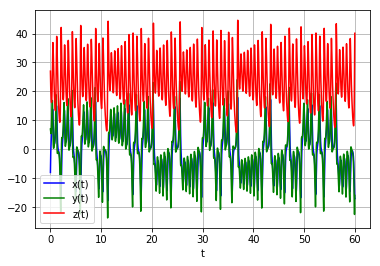

In [4]:
# Simulate
t = np.arange(0, 60, 0.01)
init_state = [-8,7,27]

sol = odeint(lorenz, init_state, t)

plt.plot(t, sol[:, 0], 'b', label='x(t)')
plt.plot(t, sol[:, 1], 'g', label='y(t)')
plt.plot(t, sol[:, 2], 'r', label='z(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [5]:
# Calculate all the derivatives (LHS)
derivs=lorenz([sol[:,0],sol[:,1],sol[:,2]],t)

In [6]:
# list1=[[1,2,3],[4,5,6]]
# list1=np.array(list1).T
# list1

# dm,_=data_matrix(list1,3)
# dm

In [7]:
%load_ext rpy2.ipython

In [8]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [9]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### Bayesian Credible Regions approach to recover coefficients

In [10]:
# Need to standardize data?

In [11]:
dm,_ = data_matrix(sol,3)
dm = dm[:,1:]

In [15]:
dm

array([[ -8.00000000e+00,   7.00000000e+00,   2.70000000e+01, ...,
          1.32300000e+03,   5.10300000e+03,   1.96830000e+04],
       [ -6.58102263e+00,   6.81474517e+00,   2.57931491e+01, ...,
          1.19785323e+03,   4.53375823e+03,   1.71598349e+04],
       [ -5.31713020e+00,   6.58540802e+00,   2.47217663e+01, ...,
          1.07212364e+03,   4.02477571e+03,   1.51090964e+04],
       ..., 
       [ -1.69029635e+01,  -1.97795442e+01,   3.59881112e+01, ...,
          1.40796420e+04,  -2.56173609e+04,   4.66097916e+04],
       [ -1.70953834e+01,  -1.80361453e+01,   3.82202943e+01, ...,
          1.24331588e+04,  -2.63470369e+04,   5.58318579e+04],
       [ -1.70864465e+01,  -1.59519678e+01,   4.00869304e+01, ...,
          1.02007318e+04,  -2.56342059e+04,   6.44181735e+04]])

In [16]:
np.linalg.cond(np.dot(dm.T,dm))

89487126102.475693

In [18]:
rstring="""
function(x,y){
source('~/Desktop/research/sparsebayes/bcr/BayesPen.R')
library(mvtnorm)
set.seed(77)

# Fit the model
prior = list(varE=list(df=3,S=1),varBR=list(df=3,S=1))
example_fit = Bayes.pen(y, x, prior=prior,nIter=10000)
example_fit
}
"""

In [25]:
rfunc = robjects.r(rstring)

In [32]:
fit = rfunc(dm,derivs[1])

Iter:  200
 
time/iter:  0
 
varE:  9.775
 
varB:  18.133


------------------------------------------------------------


Iter:  400
 
time/iter:  0.001
 
varE:  2.401
 
varB:  14.226


------------------------------------------------------------


Iter:  600
 
time/iter:  0.001
 
varE:  1.172
 
varB:  17.006


------------------------------------------------------------


Iter:  800
 
time/iter:  0.001
 
varE:  0.86
 
varB:  22.632


------------------------------------------------------------


Iter:  1000
 
time/iter:  0.001
 
varE:  0.675
 
varB:  22.564


------------------------------------------------------------


Iter:  1200
 
time/iter:  0.002
 
varE:  0.593
 
varB:  22.523


------------------------------------------------------------


Iter:  1400
 
time/iter:  0.001
 
varE:  0.528
 
varB:  13.53


------------------------------------------------------------


Iter:  1600
 
time/iter:  0.001
 
varE:  0.467
 
varB:  23.772


-------------------------------------------------

In [33]:
orders = np.array(fit.rx('order.marg'))
df_p=pd.DataFrame({'orders':orders.flatten()})
df_p[:30]

,orders
0,1
1,6
2,15
3,19
4,9
5,8
6,7
7,5
8,17
9,16


In [34]:
fit.rx('coefs.joint')

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7efe6808da48 / R:0x558e4933cd08>
[Matrix]
  coefs.joint: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7efe6808d608 / R:0x558e49068970>
[-0.364781, -1.825679, -2.422341, -2.422341, ..., -0.000000, -0.000000, -0.000000, -0.000000]

In [ ]:
dx

### Vanilla spike and slab in pyMC3

In [31]:
import pymc3 as pm
import pymc3.math as pmath

In [32]:
# Calculate all the derivatives (LHS)
derivs=lorenz([sol[:,0],sol[:,1],sol[:,2]],t)

In [33]:
dm,dx=data_matrix(sol,2)

In [34]:
# Finding f(x,y,z)
b=0
X=dm[:,1:]
Y=derivs[b]
_,p=np.shape(X)

In [36]:
model_one = pm.Model()

with model_one:
    
    # Priors
    ind = pm.Bernoulli('ind',p=0.1,shape=p)
    betaO = pm.Normal('betaO',mu=0,sd=0.001,shape=p)
    betaI = pm.Uniform('betaI',lower=-20,upper=20,shape=p)
    beta = (1-ind)*betaO+ind*betaI
    alpha = pm.Normal('alpha',mu=0,sd=1)
    sigma = pm.HalfNormal('sigma',sd=1)
    # Expected value
    mu = alpha + pmath.dot(X,beta)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=Y)

In [37]:
with model_one:
    trace = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [ind]
>NUTS: [sigma_log__, alpha, betaI_interval__, betaO]
  8%|▊         | 424/5500 [00:06<01:20, 62.98it/s] INFO (theano.gof.compilelock): Waiting for existing lock by process '2965' (I am process '2966')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/joele119/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
  8%|▊         | 430/5500 [00:06<01:20, 62.84it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '2965' (I am process '2967')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/joele119/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
 10%|▉         | 533/5500 [00:16<02:29, 33.21it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '2966' (I am process '2967')
INFO (theano.gof.compilelock): To manually release the lock, dele

KeyboardInterrupt: 

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)

### LASSO

In [10]:
dm,dx = data_matrix(sol,3)

In [11]:
# which response variable we want to regress: x=0, y=1, z=2
# b=0

In [12]:
# Calculate all the derivatives (LHS)
derivs=lorenz([sol[:,0],sol[:,1],sol[:,2]],t)

In [13]:
derivs = np.column_stack((derivs[0],derivs[1],derivs[2]))

In [14]:
df = pd.DataFrame(np.column_stack((derivs,dm[:,1:])))

In [15]:
df.to_csv('lorenz_lasso.csv')

$X0
20 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  0.0381374710
X3          -1.7356691650
X4           4.9072641937
X5           0.0262619004
X6           .           
X7          -0.0001967635
X8           .           
X9          -0.0008778930
X10          .           
X11          .           
X12          0.0024050733
X13          .           
X14          .           
X15          .           
X16          .           
X17         -0.0053532941
X18          .           
X19          .           
X20          0.0023375073
X21          .           

$X1
20 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -0.2455663049
X3           1.5831224816
X4           6.8446458248
X5          -0.0164999655
X6           .           
X7           0.0039449303
X8           .           
X9          -0.0005329427
X10          .           
X11          .           
X12         -0.0089430024
X13          .           
X14          .         

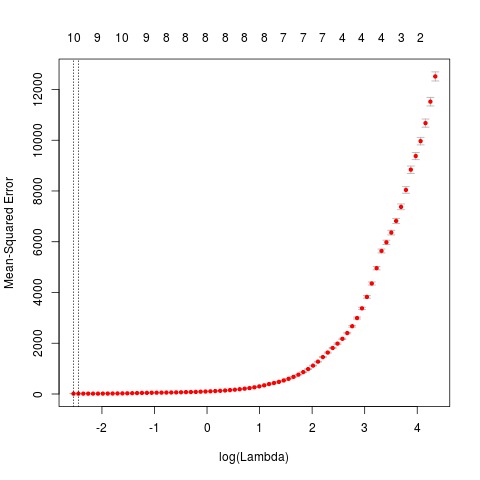

In [17]:
%%R -i df
library(glmnet)
x = df[,4:ncol(df)] 
y = df[,1:3]
# set.seed(77)
y
x<-sapply(x,as.numeric)
y<-sapply(y,as.numeric)

# Fit the model
cvfit = cv.glmnet(x, y,family="mgaussian")
plot(cvfit)

coef(cvfit,s=2)

f and h are recovered quite well - but g is not really very close. Could this have something to do with the very different scales between the coefficients?

In [18]:
b=1

In [44]:
np.shape(derivs[:][1])

(6000,)

In [19]:
df = pd.DataFrame(np.column_stack((derivs[:][b],dm[:,1:])))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

10 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -0.16804489
X1          24.40358055
X2           0.79620941
X3           .         
X4           .         
X5           .         
X6          -0.90281034
X7           .         
X8          -0.04243488
X9           .         


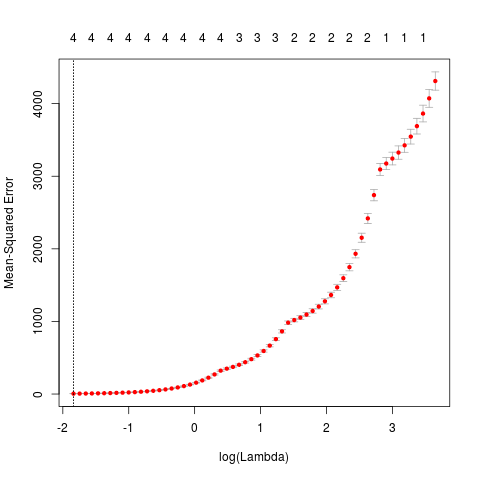

In [47]:
%%R -i df
library(glmnet)
x = df[,2:ncol(df)] 
y = df[,1]
# set.seed(77)
# y
x<-sapply(x,as.numeric)
y<-sapply(y,as.numeric)

# Fit the model
cvfit = cv.glmnet(x, y,alpha=1)
plot(cvfit)

coef(cvfit,s="lambda.min")

### Spikeslab from Ishwaran and Rao

#### This works only in R so far (though it works quite quickly and well there!)

In [24]:
# Calculate all the derivatives (LHS)
derivs=lorenz([sol[:,0],sol[:,1],sol[:,2]],t)
derivs = np.column_stack((derivs[0],derivs[1],derivs[2]))

In [25]:
dm,dx = data_matrix(sol,4)

In [26]:
b=1
df = pd.DataFrame(np.column_stack((derivs[:,b],dm[:,1:])))

In [27]:
df.to_csv('spikeslab_lorenz.csv')

In [ ]:
# This doesn't work!

# %%R -i df
# library(spikeslab)
# x = df[,2:ncol(df)] 
# y = df[,1]
# # set.seed(77)
# x<-sapply(x,as.numeric)
# y<-sapply(y,as.numeric)

# # Fit the model
# cv.spikeslab(x,y,K = 3)

In [15]:
rstring="""
function(df){
library(spikeslab)
x = df[,2:ncol(df)] 
y = df[,1]
# set.seed(77)
x<-sapply(x,as.numeric)
y<-sapply(y,as.numeric)

# Fit the model
cv.spikeslab(x,y,K = 3)
}
"""

In [16]:
rfunc = robjects.r(rstring)

In [ ]:
# fit = rfunc(df)
# This doesn't work either!

In [ ]:
dx

## Simple 1-D model from AIC-SINDy

In [5]:
def simple_1d(state,t):
    x = state
    d_x = x-0.2*x**3-0.1*x**4
    return d_x

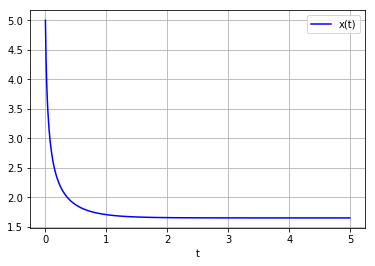

In [9]:
# Simulate
tf = 5
dt = 0.01
t = np.arange(0, tf, dt)
init_state = [5]

sol = odeint(simple_1d, init_state, t)

plt.plot(t, sol[:,0], 'b', label='x(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [10]:
# Calculate all the derivatives (LHS)
derivs=simple_1d(sol[:,0],t)

In [11]:
derivs

array([ -8.25000000e+01,  -4.87478510e+01,  -3.32915572e+01,
        -2.46575364e+01,  -1.92371946e+01,  -1.55612145e+01,
        -1.29273607e+01,  -1.09608776e+01,  -9.44491176e+00,
        -8.24593897e+00,  -7.27759415e+00,  -6.48173399e+00,
        -5.81789229e+00,  -5.25710568e+00,  -4.77814157e+00,
        -4.36510851e+00,  -4.00589541e+00,  -3.69112378e+00,
        -3.41342743e+00,  -3.16694714e+00,  -2.94696871e+00,
        -2.74965999e+00,  -2.57187650e+00,  -2.41101588e+00,
        -2.26490743e+00,  -2.13172756e+00,  -2.00993387e+00,
        -1.89821382e+00,  -1.79544407e+00,  -1.70065802e+00,
        -1.61301984e+00,  -1.53180341e+00,  -1.45637511e+00,
        -1.38617988e+00,  -1.32072945e+00,  -1.25959284e+00,
        -1.20238832e+00,  -1.14877663e+00,  -1.09845537e+00,
        -1.05115420e+00,  -1.00663077e+00,  -9.64667213e-01,
        -9.25067209e-01,  -8.87653457e-01,  -8.52265407e-01,
        -8.18757393e-01,  -7.86996955e-01,  -7.56863428e-01,
        -7.28246646e-01,

In [12]:
dm,dx = data_matrix(sol,4)
df = pd.DataFrame(np.column_stack((derivs,dm[:,1:])))

In [14]:
df

,0,1,2,3,4
0,-82.500000,5.000000,25.000000,125.000000,625.000000
1,-48.747851,4.369042,19.088525,83.398563,364.371800
2,-33.291557,3.967214,15.738788,62.439140,247.709433
3,-24.657536,3.681133,13.550740,49.882074,183.622545
4,-19.237195,3.463552,11.996191,41.549430,143.908604
5,-15.561215,3.290650,10.828380,35.632415,117.253821
6,-12.927361,3.148887,9.915491,31.222762,98.316955
7,-10.960878,3.029895,9.180264,27.815238,84.277252
8,-9.444912,2.928177,8.574219,25.106828,73.517229
9,-8.245939,2.839945,8.065289,22.904979,65.048885


In [77]:
df.to_csv('spikeslab_simple1d.csv')